I have to code up a image classification model CNN which classifies spectrograms into 5 different classes each with 500 spectrograms. These images can be located using the lables.csv file which has 2 columns image_path, class_lablel each image has a size of 100 x 100 pixels. before training the model I will need to validate the images are the correct size if they are not exclude the images from the dataset, Also check there is an even skew of images in all of the data . Next a train test split should be created where 80% of the data goes to training and the other 20% is kept for testing the models accuracy. before the model is train use the ImageDataGenerator to create more data for the model do not touch the test data, keep in mind the images are spectrograms shouldn't be too manipulated. the CNN model should be built using tensorflow and Keras, make sure to make the epochs don't run out of data and the dropout makes sense. Finally, test the CNN with the test dataset and save the model.

In [240]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from keras_tuner import RandomSearch, HyperParameters

In [241]:
import sys
from PIL import Image
sys.modules['Image'] = Image

In [242]:
print(tf.config.list_physical_devices('GPU'))

[]


In [243]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [244]:
# Load df from CSV
df = pd.read_csv('./spectrograms/labels.csv')

In [245]:
# Filter out images that are not 100x100 pixels
valid_images = []
for index, row in df.iterrows():
    img = Image.open(row['image_path'])
    if img.size == (100, 100):
        valid_images.append(row)
    img.close()

df = pd.DataFrame(valid_images)

# Check for even distribution of classes

print("Class distribution:")
print(df['class_label'].value_counts())

Class distribution:
class_label
class_b    500
class_e    500
class_c    500
class_a    500
class_d    500
Name: count, dtype: int64


In [246]:
# Split the dataset into training and testing sets (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['class_label'], random_state=42)


In [247]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='class_label',
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='class_label',
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical'
)

Found 2000 validated image filenames belonging to 5 classes.
Found 500 validated image filenames belonging to 5 classes.


In [248]:


model = Sequential([
    
    # Convolutional layers
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    
    # Flatten and dense layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

C:\Users\Work\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [249]:
model = Sequential([
    
    # Convolutional layers
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    
    # Flatten and dense layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Calculate steps per epoch
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = test_generator.n // test_generator.batch_size

In [250]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [251]:
# Train the model
epochs = 25
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=[early_stopping],
    validation_steps=validation_steps
    
)

Epoch 1/25


C:\Users\Work\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 0.2609 - loss: 1.6900 - val_accuracy: 0.3812 - val_loss: 1.5438
Epoch 2/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.4688 - loss: 1.4144 - val_accuracy: 0.3500 - val_loss: 1.5740
Epoch 3/25


c:\Program Files\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - accuracy: 0.3528 - loss: 1.5391 - val_accuracy: 0.3958 - val_loss: 1.5094
Epoch 4/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - accuracy: 0.4688 - loss: 1.4565 - val_accuracy: 0.5000 - val_loss: 1.4025
Epoch 5/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.4084 - loss: 1.4863 - val_accuracy: 0.3979 - val_loss: 1.4743
Epoch 6/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - accuracy: 0.4062 - loss: 1.6441 - val_accuracy: 0.4500 - val_loss: 1.6246
Epoch 7/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.4202 - loss: 1.4332 - val_accuracy: 0.4521 - val_loss: 1.4282
Epoch 8/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - accuracy: 0.2812 - loss: 1.6143 - val_accuracy: 0.4500 - val_loss: 1.4573
Epoch 9/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.4357 - loss: 1.4148 - val_accuracy: 0.4437 - val_loss: 1.4360
Epoch 10/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - accuracy: 0.4688 - loss: 1.3712 - val_accuracy: 0.1500 - val

In [252]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.4f}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4901 - loss: 1.4124
Test accuracy: 0.4780


In [253]:
# Save the model
model.save('spectrogram_classifier.h5')

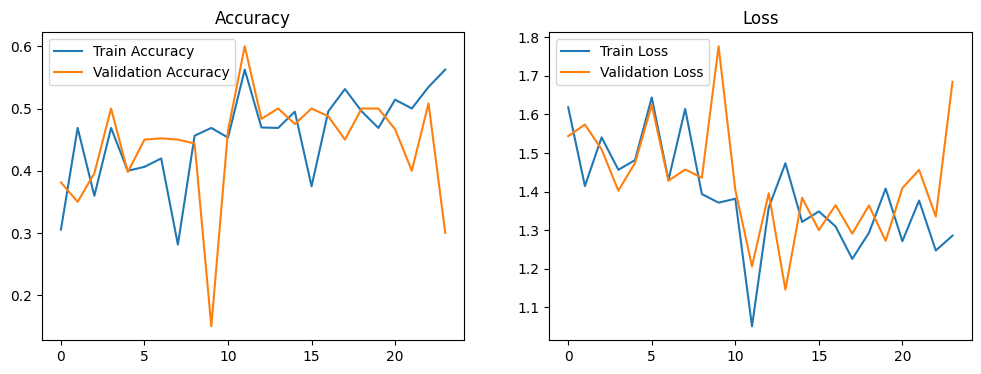

In [254]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [255]:
def build_model(hp):
    model = Sequential()
    
    # Add Conv2D layers
    for i in range(hp.Int('conv_layers', 1, 3)):
        model.add(Conv2D(
            filters=hp.Int(f'filters_{i}', 32, 128, step=32),
            kernel_size=hp.Choice(f'kernel_size_{i}', [3, 5]),
            activation='relu',
            input_shape=(100, 100, 3) if i == 0 else None
        ))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization())
    
    model.add(Flatten())
    
    # Add Dense layers
    for i in range(hp.Int('dense_layers', 1, 3)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', 128, 512, step=128),
            activation='relu',
            kernel_regularizer=l2(hp.Float(f'l2_{i}', 1e-4, 1e-2, sampling='LOG'))
        ))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', 0.2, 0.5, step=0.1)))
    
    model.add(Dense(5, activation='softmax'))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='LOG')
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [256]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='spectrogram_classification'
)

Reloading Tuner from tuner_dir\spectrogram_classification\tuner0.json


In [257]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner.search(
    train_generator,
    epochs=15,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hp.values)

Trial 20 Complete [00h 07m 53s]
val_accuracy: 0.36399999260902405

Best val_accuracy So Far: 0.44999998807907104
Total elapsed time: 03h 50m 12s
{'conv_layers': 1, 'filters_0': 96, 'kernel_size_0': 3, 'dense_layers': 3, 'units_0': 256, 'l2_0': 0.006364617251886751, 'dropout_0': 0.4, 'lr': 0.000144122155326606, 'units_1': 128, 'l2_1': 0.008518762868859345, 'dropout_1': 0.2, 'filters_1': 32, 'kernel_size_1': 5, 'units_2': 256, 'l2_2': 0.0006119224874994206, 'dropout_2': 0.30000000000000004}


In [258]:
model = tuner.hypermodel.build(best_hp)

history = model.fit(
    train_generator,
    epochs=25,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 899ms/step - accuracy: 0.2285 - loss: 8.1300 - val_accuracy: 0.2200 - val_loss: 5.5296
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 934ms/step - accuracy: 0.2834 - loss: 5.4501 - val_accuracy: 0.2860 - val_loss: 5.0681
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 927ms/step - accuracy: 0.3115 - loss: 5.0173 - val_accuracy: 0.2620 - val_loss: 4.6883
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 893ms/step - accuracy: 0.3497 - loss: 4.5495 - val_accuracy: 0.2680 - val_loss: 4.3619
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 893ms/step - accuracy: 0.3568 - loss: 4.2473 - val_accuracy: 0.2020 - val_loss: 4.1915
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 57s 896ms/step - accuracy: 0.3817 - loss: 3.9674 - val_accuracy: 0.2640 - val_loss: 3.9047
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 57s 896ms/step - accuracy: 0.3918 - loss: 3.7225 - val_accuracy: 0.3120 - val_loss: 3.7060
Epoch 8/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 57s 898ms/step - accuracy: 0.4343 - loss: 3.5244 - val_accu

In [259]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy}')

# Save the model
model.save('spectrogram_classifier_model.h5')

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.4533 - loss: 3.0399


Test accuracy: 0.45399999618530273


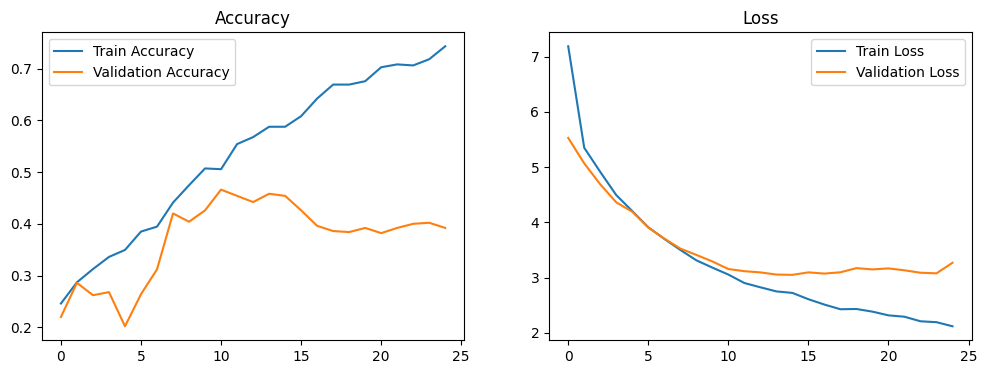

In [260]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()